Preparazione pacchetti

In [1]:
# ==============================================
# - BLOCCO 1 — Caricamento e unione dataset
# ==============================================
import os
import pandas as pd
import pyarrow.parquet as pq

DATASET_DIR = r"C:\Users\maria\Desktop\Zeek_ML\Final-Dataset"

all_dfs = []
for filename in os.listdir(DATASET_DIR):
    file_path = os.path.join(DATASET_DIR, filename)

    if filename.endswith(".csv"):
        print(f"[INFO] Caricamento CSV: {filename}")
        df = pd.read_csv(file_path)
        all_dfs.append(df)

    elif filename.endswith(".parquet"):
        print(f"[INFO] Caricamento PARQUET: {filename}")
        df = pd.read_parquet(file_path)
        all_dfs.append(df)

if not all_dfs:
    raise FileNotFoundError(f"Nessun file CSV o Parquet trovato in {DATASET_DIR}")

data_clean = pd.concat(all_dfs, ignore_index=True)
print(f"[INFO] Dataset combinato: {data_clean.shape[0]} righe, {data_clean.shape[1]} colonne")


[INFO] Caricamento PARQUET: part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-23fdcfa3-9dd3-4c72-886c-e945bfcf92e1-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-2b76f9cc-0710-45e4-9e33-98ad5808ee79-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-745e350a-da9e-4619-bd52-8cc23bb41ad5-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet
[INFO] Caricamento CSV: part-00000-8c53ceaf-1fd1-4711-aa7d-26d0c5323dab-c000.csv
[INFO] Caricamento PARQUET: part-00000-94d13437-ae00-4a8c-9f38-edd0196cfdee-c000.snappy.parquet
[INFO] Caricamento PARQUET: part-00000-9a46dd05-4b06-4a

In [2]:
# ===============================================
# Esplorazione colonne e struttura dataset
# ===============================================

print("\n[INFO] ✅ Dataset combinato correttamente.")
print(f"Totale righe: {data_clean.shape[0]}")
print(f"Totale colonne: {data_clean.shape[1]}")

# 🔹 Mostra elenco completo delle colonne
print("\n[INFO] Elenco colonne:")
for i, col in enumerate(data_clean.columns, 1):
    print(f"{i:02d}. {col}")

# 🔹 Mostra prime righe del dataset
print("\n[INFO] Prime righe del dataset:")
display(data_clean.head())

# 🔹 Tipi di dati per ciascuna colonna
print("\n[INFO] Tipi di dati per colonna:")
print(data_clean.dtypes)

# 🔹 Controllo valori nulli
print("\n[INFO] Conteggio valori nulli per colonna:")
print(data_clean.isnull().sum())

# 🔹 Se esiste una colonna etichetta, mostra la distribuzione
possible_labels = [c for c in data_clean.columns if "label" in c.lower()]
if possible_labels:
    print("\n[INFO] Possibili colonne etichetta trovate:")
    for lbl in possible_labels:
        print(f" - {lbl}")
        print(data_clean[lbl].value_counts(dropna=False))
else:
    print("\n[INFO] Nessuna colonna contenente 'label' trovata.")



[INFO] ✅ Dataset combinato correttamente.
Totale righe: 19262879
Totale colonne: 42

[INFO] Elenco colonne:
01. resp_pkts
02. service
03. orig_ip_bytes
04. local_resp
05. missed_bytes
06. proto
07. duration
08. conn_state
09. dest_ip_zeek
10. orig_pkts
11. community_id
12. resp_ip_bytes
13. dest_port_zeek
14. orig_bytes
15. local_orig
16. datetime
17. history
18. resp_bytes
19. uid
20. src_port_zeek
21. ts
22. src_ip_zeek
23. label_tactic
24. label_technique
25. label_binary
26. 2021-12-12 - 2021-12-19
27. 2021-12-19 - 2021-12-26
28. 2021-12-26 - 2022-01-02
29. 2022-01-02 - 2022-01-09
30. 2022-08-28 - 2022-09-04
31. 2022-09-04 - 2022-09-11
32. 2022-09-11 - 2022-09-18
33. 2022-09-18 - 2022-09-25
34. 2022-09-25 - 2022-10-02
35. 2022-10-02 - 2022-10-09
36. 2022-10-09 - 2022-10-16
37. 2022-10-16 - 2022-10-23
38. 2022-10-23 - 2022-10-30
39. 2022-01-09 - 2022-01-16
40. 2022-01-16 - 2022-01-23
41. 2022-02-06 - 2022-02-13
42. 2022-02-13 - 2022-02-20

[INFO] Prime righe del dataset:


,resp_pkts,service,orig_ip_bytes,local_resp,missed_bytes,proto,duration,conn_state,dest_ip_zeek,orig_pkts,...,2022-09-18 - 2022-09-25,2022-09-25 - 2022-10-02,2022-10-02 - 2022-10-09,2022-10-09 - 2022-10-16,2022-10-16 - 2022-10-23,2022-10-23 - 2022-10-30,2022-01-09 - 2022-01-16,2022-01-16 - 2022-01-23,2022-02-06 - 2022-02-13,2022-02-13 - 2022-02-20
0,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2620.0,ssh,277936.0,False,44.0,tcp,4132.060737,S1,143.88.9.13,4032.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64.0,ssh,11824.0,False,0.0,tcp,17.406988,SF,143.88.10.11,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



[INFO] Tipi di dati per colonna:
resp_pkts                         float64
service                            object
orig_ip_bytes                     float64
local_resp                         object
missed_bytes                      float64
proto                              object
duration                          float64
conn_state                         object
dest_ip_zeek                       object
orig_pkts                         float64
community_id                       object
resp_ip_bytes                     float64
dest_port_zeek                    float64
orig_bytes                        float64
local_orig                         object
datetime                   datetime64[ns]
history                            object
resp_bytes                        float64
uid                                object
src_port_zeek                     float64
ts                                float64
src_ip_zeek                        object
label_tactic                       object


In [3]:
# ==============================================
# 🧩 BLOCCO 2 — Pulizia e pre-processing base
# ==============================================
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# Colonne numeriche principali
numerical_cols = [
    'orig_bytes', 'resp_bytes', 'duration', 'orig_pkts',
    'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes'
]

# 🔹 Rimozione colonne con >99% NaN
def get_high_null_columns(df, threshold=99.0):
    null_percent = (df.isna().sum() / len(df)) * 100
    return null_percent[null_percent > threshold].index.tolist()

cols_to_drop = get_high_null_columns(data_clean)
if cols_to_drop:
    data_clean = data_clean.drop(columns=cols_to_drop)
    print(f"[INFO] Colonne rimosse (>99% NaN): {cols_to_drop}")
else:
    print("[INFO] Nessuna colonna rimossa (>99% NaN)")

# 🔹 Riempimento valori numerici mancanti
global_means = data_clean[numerical_cols].mean()
data_clean[numerical_cols] = data_clean[numerical_cols].fillna(global_means).fillna(0)

# 🔹 Riempimento valori categorici mancanti
for col in data_clean.select_dtypes(include=['object']).columns:
    data_clean[col] = data_clean[col].fillna("unknown")

# 🔹 Filtra tattiche MITRE valide
valid_tactics = [
    "Reconnaissance", "Discovery", "Credential Access", "Privilege Escalation",
    "Exfiltration", "Lateral Movement", "Resource Development", "Initial Access",
    "Persistence", "Defense Evasion"
]
before_filter = len(data_clean)
data_clean = data_clean[data_clean['label_tactic'].isin(valid_tactics)]
after_filter = len(data_clean)
print(f"[INFO] Filtrati {before_filter - after_filter} record non MITRE")

# 🔹 Rimozione duplicati
key_cols = ['uid', 'ts', 'src_ip_zeek', 'dest_ip_zeek', 'src_port_zeek', 'dest_port_zeek']
if all(col in data_clean.columns for col in key_cols):
    data_clean = data_clean.drop_duplicates(subset=key_cols)
else:
    data_clean = data_clean.drop_duplicates()

print(f"[INFO] Dataset pulito: {data_clean.shape[0]} righe")

# 🔹 Label encoding
label_encoder_tactic = LabelEncoder()
data_clean['label_tactic_encoded'] = label_encoder_tactic.fit_transform(data_clean['label_tactic'])
SAVE_DIR = r"C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit"
os.makedirs(SAVE_DIR, exist_ok=True)

with open(os.path.join(SAVE_DIR, "label_encoder_tactic.pkl"), "wb") as f:
    pickle.dump(label_encoder_tactic, f)
print(f"[INFO] LabelEncoder per 'label_tactic' salvato in {SAVE_DIR}")

label_encoder_technique = LabelEncoder()
data_clean['label_technique_encoded'] = label_encoder_technique.fit_transform(data_clean['label_technique'])

print(f"[INFO] Classi MITRE trovate: {list(label_encoder_tactic.classes_)}")
print(data_clean['label_tactic'].value_counts())


[INFO] Colonne rimosse (>99% NaN): ['2021-12-12 - 2021-12-19', '2021-12-19 - 2021-12-26', '2021-12-26 - 2022-01-02', '2022-01-02 - 2022-01-09', '2022-08-28 - 2022-09-04', '2022-09-04 - 2022-09-11', '2022-09-11 - 2022-09-18', '2022-09-18 - 2022-09-25', '2022-09-25 - 2022-10-02', '2022-10-02 - 2022-10-09', '2022-10-09 - 2022-10-16', '2022-10-16 - 2022-10-23', '2022-10-23 - 2022-10-30', '2022-01-09 - 2022-01-16', '2022-01-16 - 2022-01-23', '2022-02-06 - 2022-02-13', '2022-02-13 - 2022-02-20']
[INFO] Filtrati 9632038 record non MITRE
[INFO] Dataset pulito: 348396 righe
[INFO] LabelEncoder per 'label_tactic' salvato in C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit
[INFO] Classi MITRE trovate: ['Credential Access', 'Defense Evasion', 'Discovery', 'Exfiltration', 'Initial Access', 'Lateral Movement', 'Persistence', 'Privilege Escalation', 'Reconnaissance', 'Resource Development']
label_tactic
Resource Development    262412
Reconnaissance           64908
Discovery                18106
Defense 

[INFO] Analisi outlier in corso...


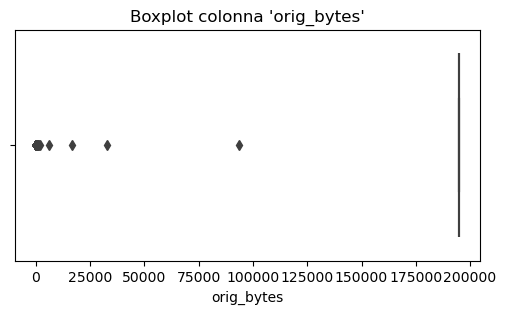

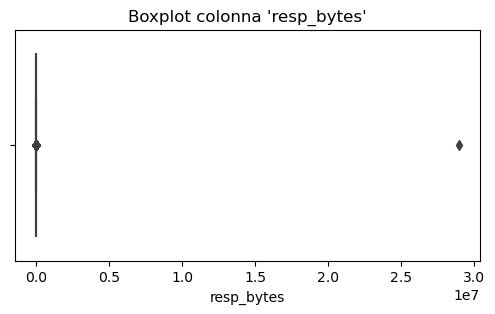

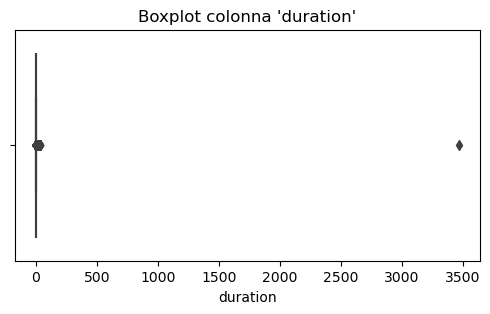

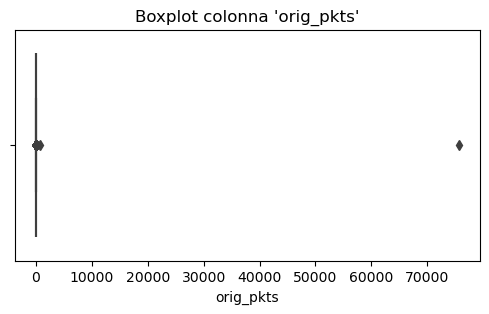

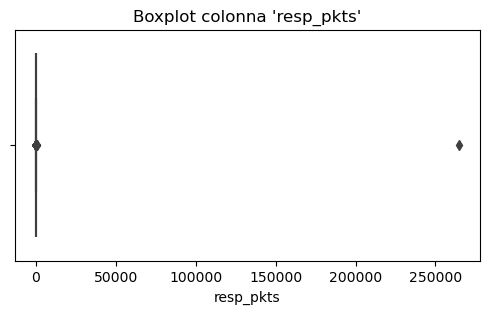

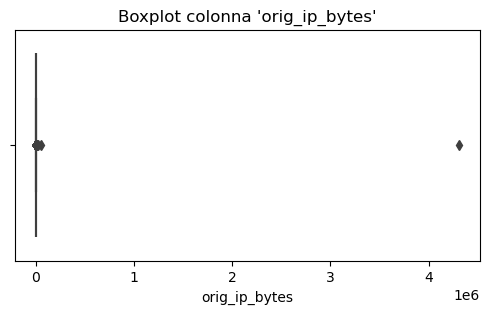

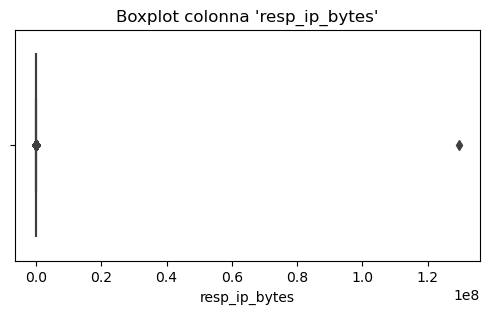

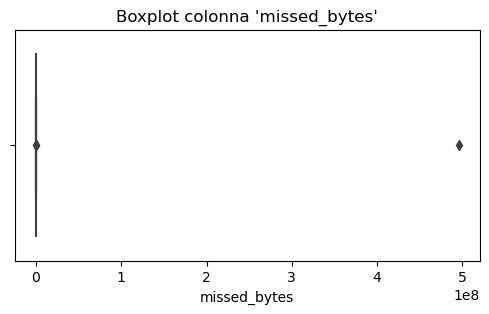

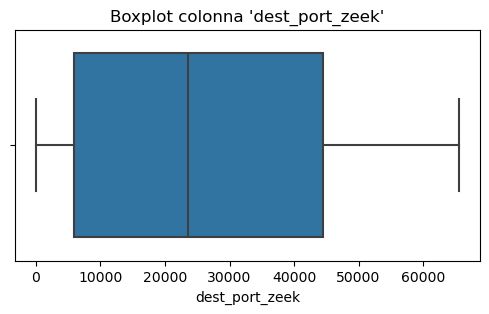

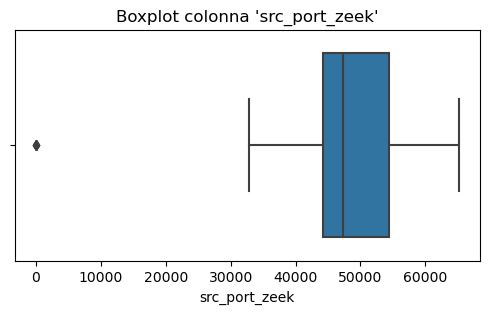

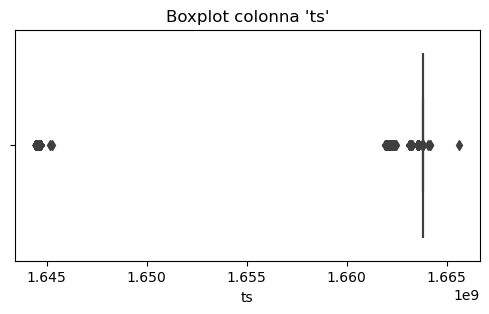

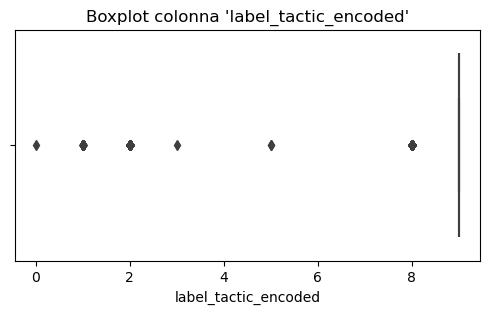

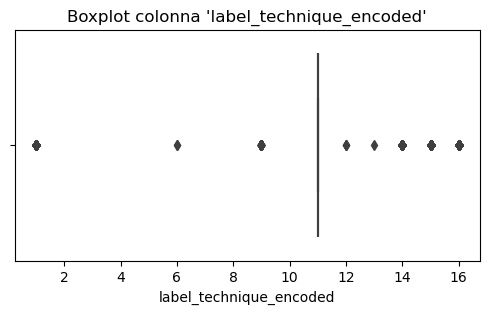

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


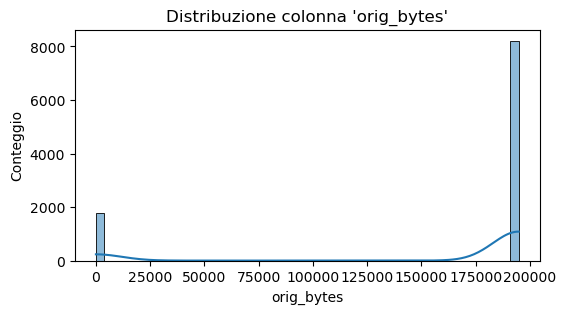

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


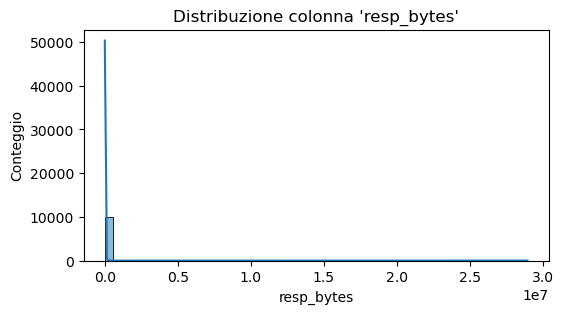

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


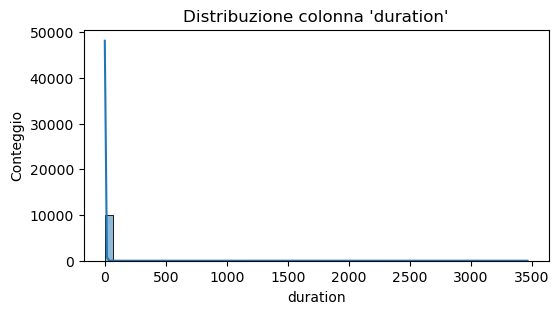

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


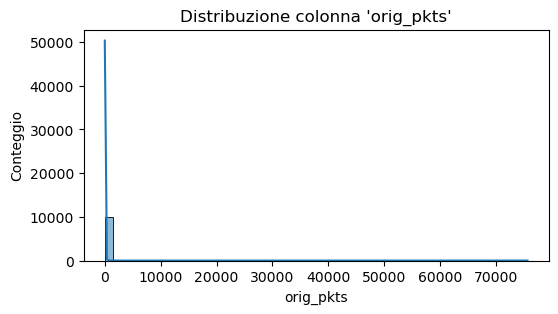

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


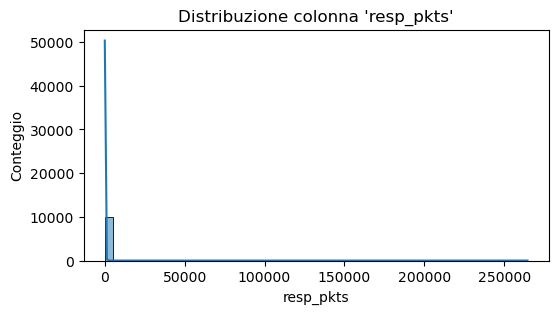

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


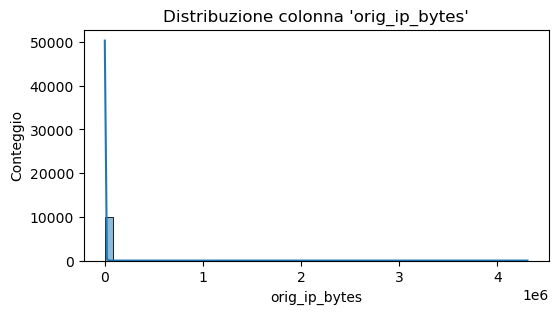

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


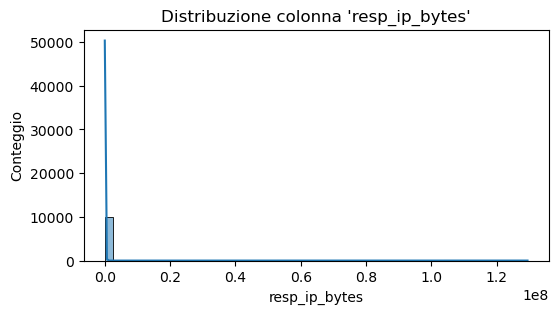

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


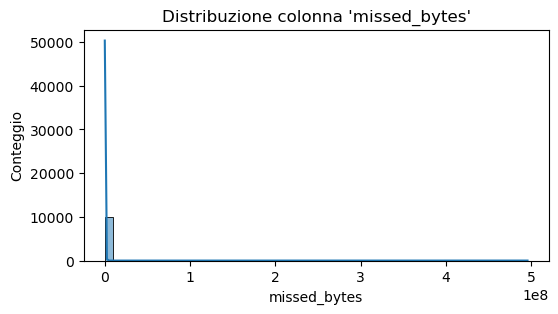

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


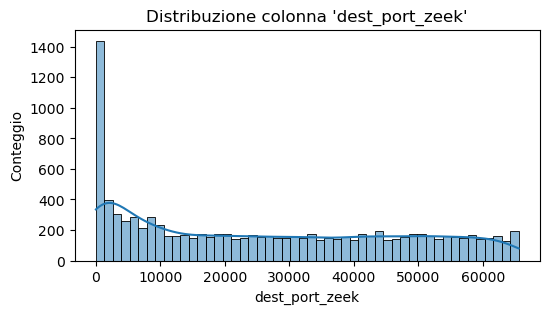

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


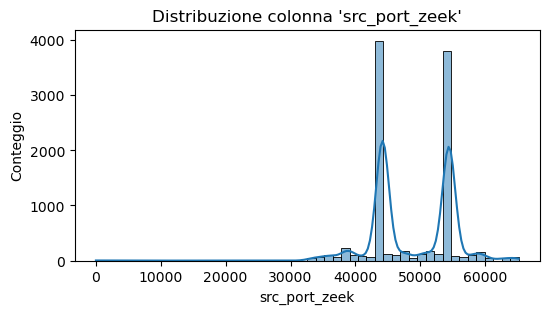

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


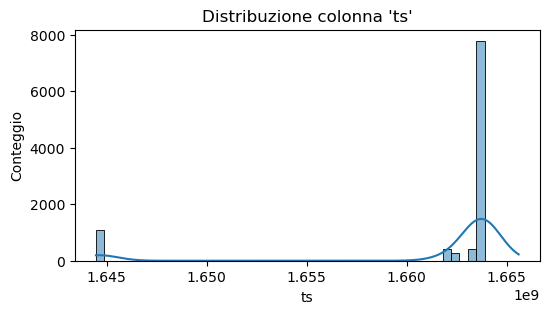

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


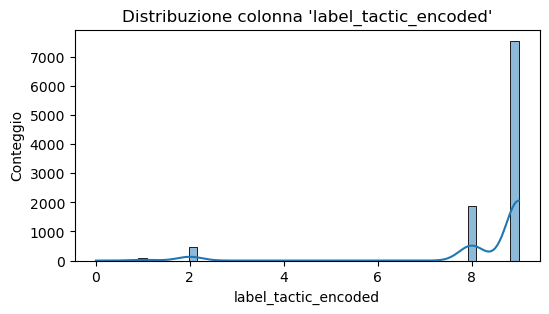

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


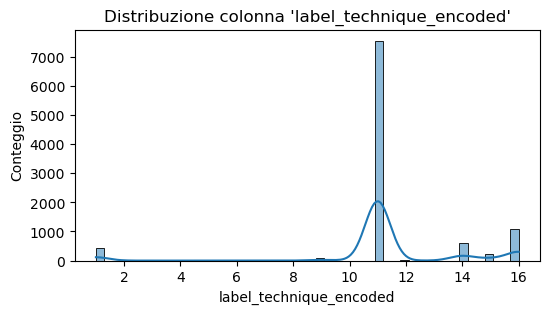

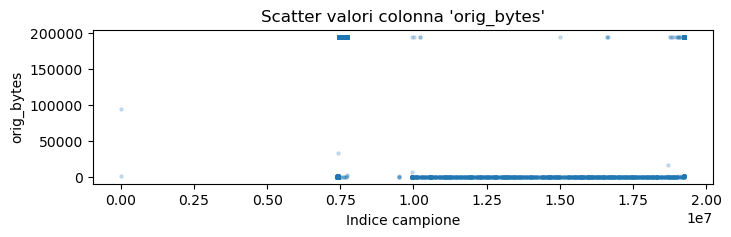

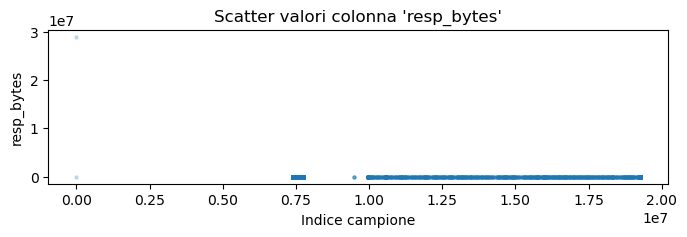

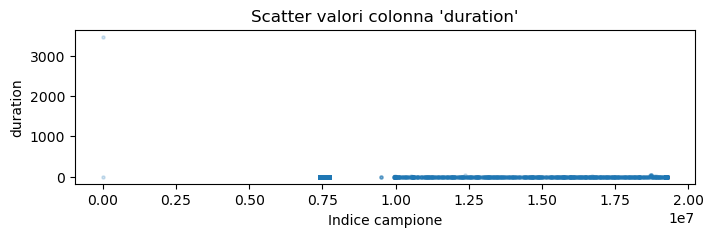

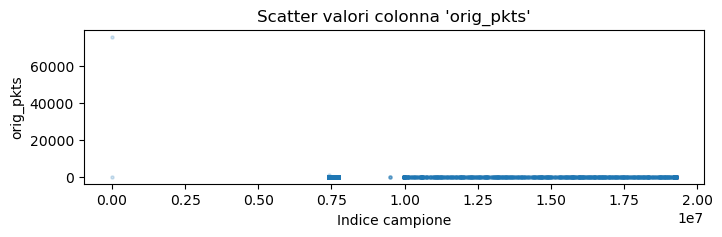

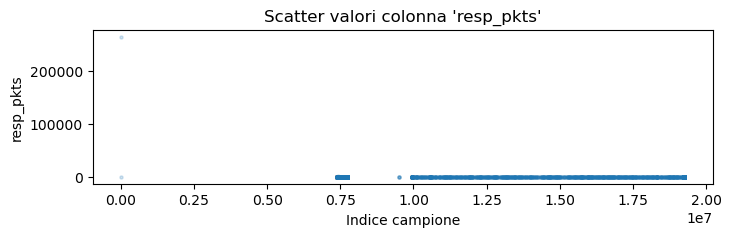

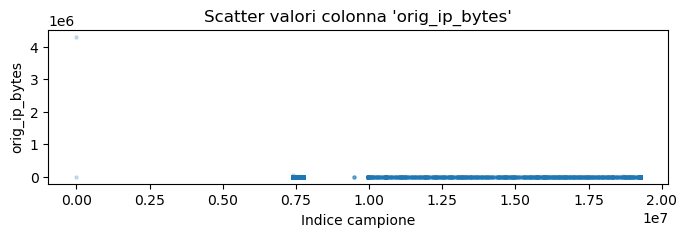

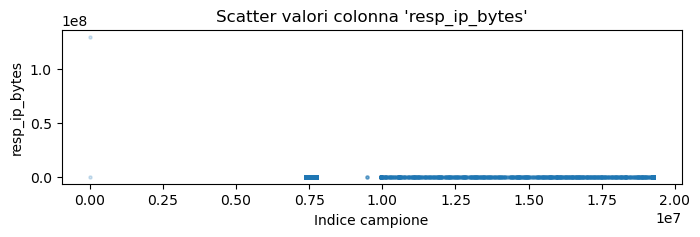

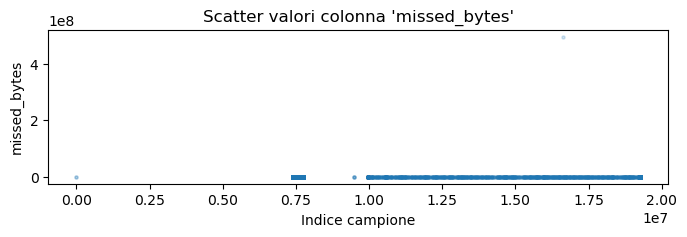

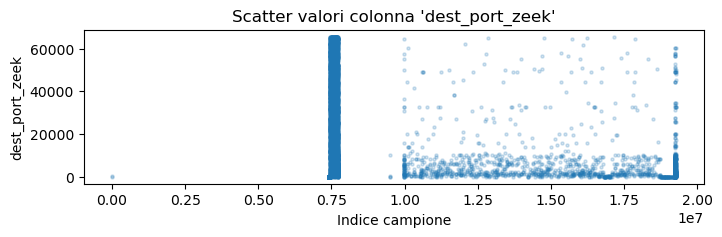

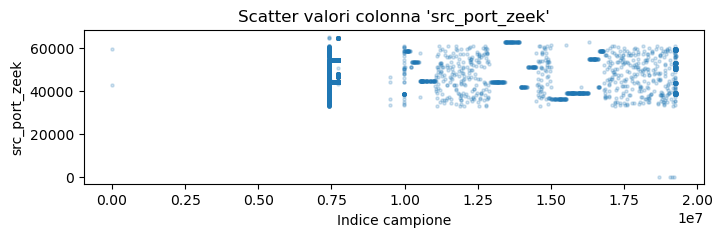

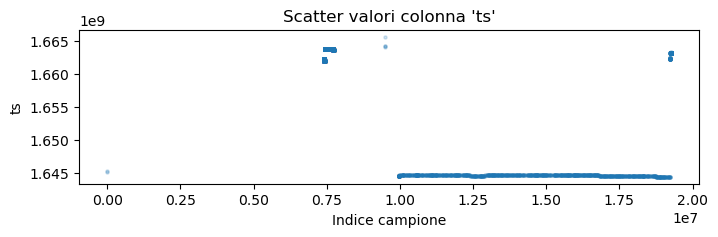

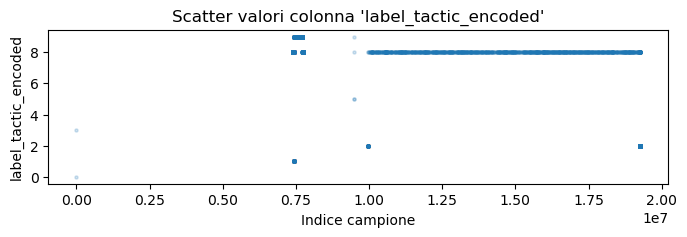

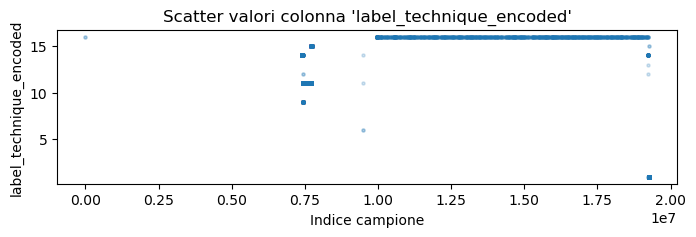

In [4]:
# ==============================================
# - BLOCCO 3 — Analisi e gestione outlier (aggiornato)
# ==============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("[INFO] Analisi outlier in corso...")

# 🔹 Definire tutte le colonne numeriche che vogliamo analizzare, comprese le label encode
numeric_cols = [
    'orig_bytes', 'resp_bytes', 'duration', 'orig_pkts', 
    'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes',
    'dest_port_zeek', 'src_port_zeek', 'ts', 
    'label_tactic_encoded', 'label_technique_encoded'
]

# 🔹 Campionamento per grafici (velocizza la visualizzazione)
sample_size = min(10000, len(data_clean))
sampled = data_clean[numeric_cols].sample(n=sample_size, random_state=42)

# 🔹 Gestione valori inf
sampled.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1️⃣ Boxplot per colonna singola
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=sampled[col])
    plt.title(f"Boxplot colonna '{col}'")
    plt.xlabel(col)
    plt.show()

# 2️⃣ Histogrammi con KDE
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(sampled[col], bins=50, kde=True)
    plt.title(f"Distribuzione colonna '{col}'")
    plt.xlabel(col)
    plt.ylabel("Conteggio")
    plt.show()

# 3️⃣ Scatter plot valori vs indice
for col in numeric_cols:
    plt.figure(figsize=(8,2))
    plt.scatter(sampled.index, sampled[col], alpha=0.2, s=5)
    plt.title(f"Scatter valori colonna '{col}'")
    plt.xlabel("Indice campione")
    plt.ylabel(col)
    plt.show()


In [5]:
# ==============================================
# - BLOCCO 4 — Gestione outlier
# ==============================================
from scipy import stats

print("[INFO] Inizio gestione outlier...")

# 🔹 Copia dataset per sicurezza
data_preproc = data_clean.copy()

# 🔹 Metodo IQR per rilevare outlier
Q1 = data_preproc[numerical_cols].quantile(0.25)
Q3 = data_preproc[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# 🔹 Limiti per outlier (1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 🔹 Rimuovi righe con almeno un outlier numerico
before_outlier = data_preproc.shape[0]
data_preproc = data_preproc[~((data_preproc[numerical_cols] < lower_bound) | 
                              (data_preproc[numerical_cols] > upper_bound)).any(axis=1)]
after_outlier = data_preproc.shape[0]
print(f"[INFO] Righe rimosse per outlier: {before_outlier - after_outlier} (rimaste {after_outlier})")

# 🔹 Optional: log-transform sulle feature fortemente asimmetriche
for col in numerical_cols:
    if (data_preproc[col] <= 0).any():
        continue  # salta valori <=0
    skewness = data_preproc[col].skew()
    if abs(skewness) > 2:  # forte asimmetria
        data_preproc[col] = np.log1p(data_preproc[col])
        print(f"[INFO] Applicata log1p su '{col}' per ridurre skewness ({skewness:.2f})")


[INFO] Inizio gestione outlier...
[INFO] Righe rimosse per outlier: 86290 (rimaste 262106)


In [6]:
# ==============================================
# - BLOCCO 5 — Feature Engineering e Scaling
# ==============================================
from sklearn.preprocessing import RobustScaler, LabelEncoder
import numpy as np
import pandas as pd

print("[INFO] Inizio feature engineering e scaling (versione robusta)...")

# 🔹 Copia del dataset pulito
data_preproc = data_clean.copy()

# 🔹 Identifica colonne numeriche e categoriche
numerical_cols = data_preproc.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data_preproc.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in ['label_tactic','label_technique']]

print(f"[INFO] Colonne numeriche: {len(numerical_cols)} | Colonne categoriche: {len(categorical_cols)}")

# 🔹 Scaling numerico con RobustScaler
scaler = RobustScaler()
data_preproc[numerical_cols] = scaler.fit_transform(data_preproc[numerical_cols])
print("[INFO] Scaling numerico completato (RobustScaler)")

# 🔹 Suddivisione per cardinalità
max_categories = 20
low_card_cols = [c for c in categorical_cols if data_preproc[c].nunique() <= max_categories]
high_card_cols = [c for c in categorical_cols if c not in low_card_cols]

print(f"[INFO] One-hot su colonne low-cardinality: {low_card_cols}")
print(f"[INFO] Label encoding su colonne high-cardinality: {high_card_cols}")

# 🔹 One-hot encoding (bassa cardinalità)
if low_card_cols:
    dummies = pd.get_dummies(data_preproc[low_card_cols], drop_first=True, dtype=int)
    data_preproc = pd.concat([data_preproc.drop(columns=low_card_cols), dummies], axis=1)
    print("[INFO] One-hot encoding completato")

# 🔹 Label encoding (alta cardinalità)
for col in high_card_cols:
    le = LabelEncoder()
    data_preproc[col] = le.fit_transform(data_preproc[col].astype(str))
    print(f"[INFO] Label encoding applicato su '{col}' ({data_preproc[col].nunique()} categorie)")

# 🔹 Controllo finale tipi di dato
print("[INFO] Tipi di colonna dopo feature engineering:")
print(data_preproc.dtypes.value_counts())

print(f"[INFO] Dataset finale preprocessing: {data_preproc.shape[0]} righe, {data_preproc.shape[1]} colonne totali.")


[INFO] Inizio feature engineering e scaling (versione robusta)...
[INFO] Colonne numeriche: 13 | Colonne categoriche: 11
[INFO] Scaling numerico completato (RobustScaler)
[INFO] One-hot su colonne low-cardinality: ['local_resp', 'proto', 'conn_state', 'local_orig', 'label_binary']
[INFO] Label encoding su colonne high-cardinality: ['service', 'dest_ip_zeek', 'community_id', 'history', 'uid', 'src_ip_zeek']
[INFO] One-hot encoding completato
[INFO] Label encoding applicato su 'service' (21 categorie)
[INFO] Label encoding applicato su 'dest_ip_zeek' (288 categorie)
[INFO] Label encoding applicato su 'community_id' (343798 categorie)
[INFO] Label encoding applicato su 'history' (112 categorie)
[INFO] Label encoding applicato su 'uid' (348396 categorie)
[INFO] Label encoding applicato su 'src_ip_zeek' (27 categorie)
[INFO] Tipi di colonna dopo feature engineering:
int32             25
float64           13
object             2
datetime64[ns]     1
Name: count, dtype: int64
[INFO] Dataset f

[INFO] Inizio analisi correlazioni e PCA...

[INFO] Matrice di correlazione numerica (completa):
                         resp_pkts  service  orig_ip_bytes  missed_bytes  duration  dest_ip_zeek  orig_pkts  community_id  resp_ip_bytes  dest_port_zeek  orig_bytes  history  resp_bytes    uid  \
resp_pkts                    1.000   -0.003          0.548         0.000     0.478        -0.002      0.997         0.000          1.000          -0.003       0.000    0.002       1.000  0.002   
service                     -0.003    1.000         -0.005         0.002     0.027         0.141     -0.007         0.003         -0.001           0.350       0.006    0.240      -0.002 -0.000   
orig_ip_bytes                0.548   -0.005          1.000         0.000     0.826         0.002      0.590         0.001          0.551          -0.006       0.000    0.006       0.551  0.001   
missed_bytes                 0.000    0.002          0.000         1.000     0.006         0.026      0.000         0.0

C:\Users\maria\AppData\Local\Temp\ipykernel_2884\63056837.py:52: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


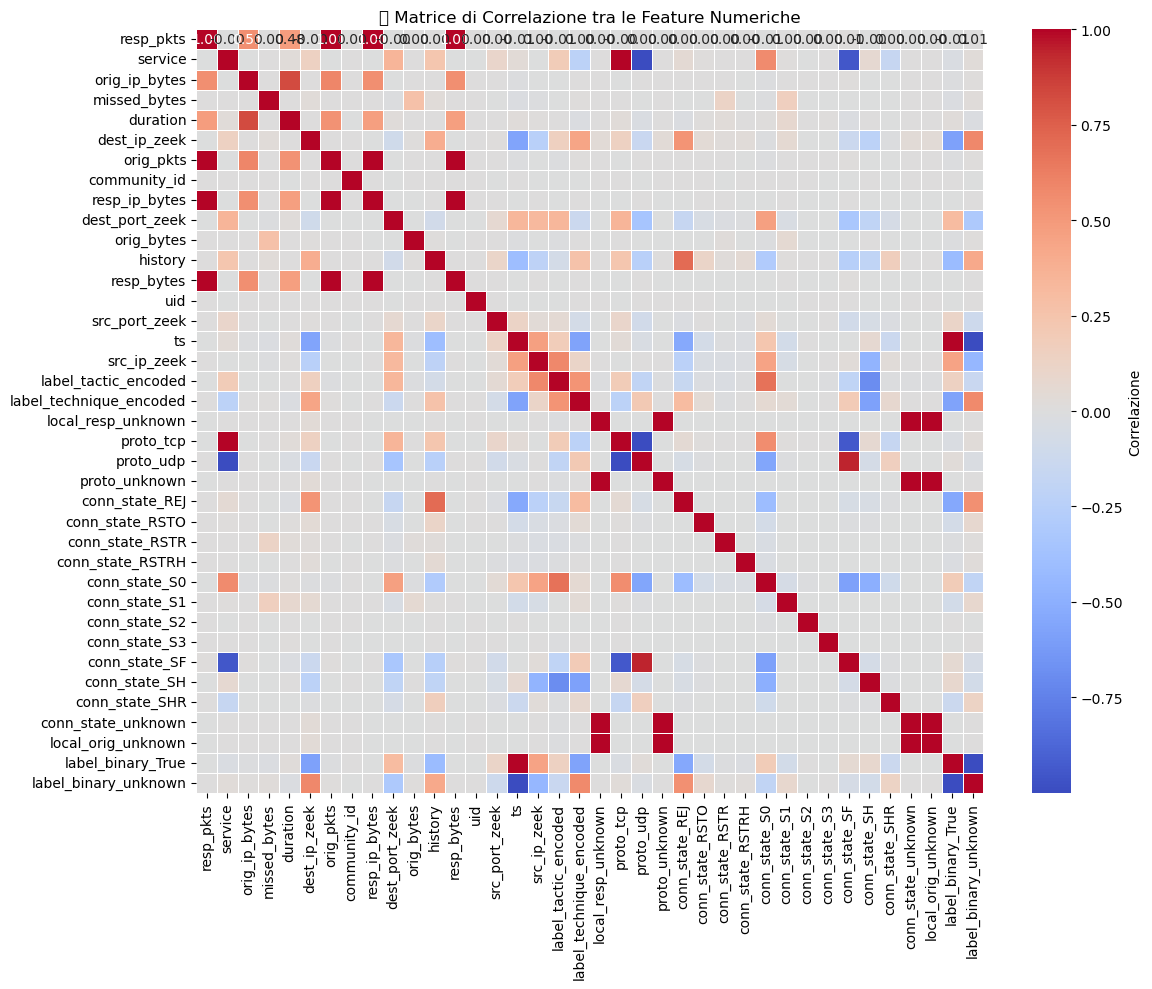


- INTERPRETAZIONE HEATMAP:
- Le celle più rosse indicano correlazioni positive forti.
- Le celle più blu indicano correlazioni negative forti.
- Le zone neutre (bianco/chiaro) indicano bassa correlazione.
- Analizzare i gruppi di feature molto correlate aiuta a ridurre la dimensionalità o evitare ridondanza.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


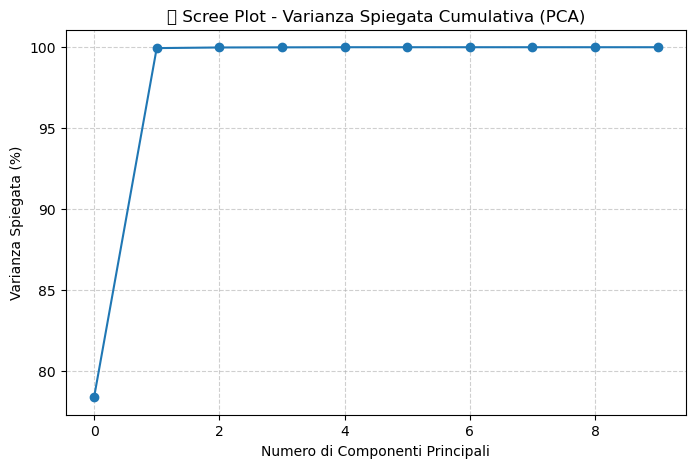


[INFO] Varianza spiegata da ciascuna componente PCA:
  ➤ PC1: 78.40%
  ➤ PC2: 21.55%
  ➤ PC3: 0.04%
  ➤ PC4: 0.01%
  ➤ PC5: 0.01%
  ➤ PC6: 0.00%
  ➤ PC7: 0.00%
  ➤ PC8: 0.00%
  ➤ PC9: 0.00%
  ➤ PC10: 0.00%

[INFO] Totale varianza spiegata dalle prime 10 componenti: 100.00%

🧠 INTERPRETAZIONE PCA:
- Ogni componente principale (PC1, PC2, ...) rappresenta una combinazione lineare delle feature originali.
- Più alta è la varianza spiegata → più informazione cattura quella componente.
- Le prime 2–3 componenti spesso spiegano gran parte della varianza, consentendo di visualizzare i dati in 2D/3D.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


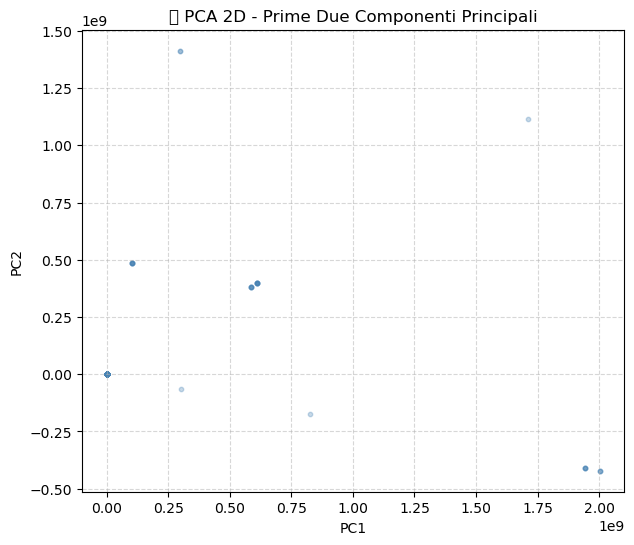


🧠 INTERPRETAZIONE SCATTER PCA:
- Ogni punto rappresenta un’osservazione proiettata nello spazio 2D delle componenti principali.
- Se emergono gruppi visivamente distinti, può esserci una separazione naturale tra categorie di minacce.



In [7]:
# ==============================================
# 🧩 BLOCCO 6 — Analisi delle correlazioni e PCA (robusto + spiegato)
# ==============================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

print("[INFO] Inizio analisi correlazioni e PCA...")

# 🔹 Seleziona solo le colonne numeriche dopo il preprocessing
num_cols = data_preproc.select_dtypes(include=[np.number]).columns.tolist()

# 🔹 Filtra eventuali colonne costanti o con NaN
valid_cols = [c for c in num_cols if data_preproc[c].nunique() > 1]
corr_matrix = data_preproc[valid_cols].corr()

# 🔹 Sostituisci valori inf o NaN per sicurezza
corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# ==============================================
# 1️⃣ Mostra matrice numerica completa
# ==============================================
print("\n[INFO] Matrice di correlazione numerica (completa):")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(corr_matrix.round(3))

# Spiegazione
print("""
🧠 INTERPRETAZIONE:
- Valori prossimi a +1 → forte correlazione positiva (le feature crescono insieme)
- Valori prossimi a -1 → forte correlazione negativa (una cresce, l’altra diminuisce)
- Valori vicini a 0 → nessuna correlazione lineare rilevante
""")

# ==============================================
# 2️⃣ Heatmap della matrice di correlazione
# ==============================================
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,                # 🔹 Mostra i valori numerici nella matrice
    fmt=".2f",                 # 🔹 Mostra due decimali
    cmap="coolwarm",           # 🔹 Colormap bilanciata
    center=0, 
    linewidths=0.5, 
    cbar_kws={'label': 'Correlazione'}
)
plt.title("🔍 Matrice di Correlazione tra le Feature Numeriche")
plt.tight_layout()
plt.show()

print("""
- INTERPRETAZIONE HEATMAP:
- Le celle più rosse indicano correlazioni positive forti.
- Le celle più blu indicano correlazioni negative forti.
- Le zone neutre (bianco/chiaro) indicano bassa correlazione.
- Analizzare i gruppi di feature molto correlate aiuta a ridurre la dimensionalità o evitare ridondanza.
""")

# ==============================================
# 3️⃣ PCA - Analisi delle Componenti Principali
# ==============================================
pca = PCA(n_components=min(10, len(valid_cols)), random_state=42)
pca_result = pca.fit_transform(data_preproc[valid_cols].fillna(0))
explained_variance = pca.explained_variance_ratio_ * 100

# 🔹 Scree Plot — Varianza spiegata
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title("📈 Scree Plot - Varianza Spiegata Cumulativa (PCA)")
plt.xlabel("Numero di Componenti Principali")
plt.ylabel("Varianza Spiegata (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n[INFO] Varianza spiegata da ciascuna componente PCA:")
for i, var in enumerate(explained_variance):
    print(f"  ➤ PC{i+1}: {var:.2f}%")

print(f"\n[INFO] Totale varianza spiegata dalle prime {len(explained_variance)} componenti: {np.sum(explained_variance):.2f}%")

print("""
🧠 INTERPRETAZIONE PCA:
- Ogni componente principale (PC1, PC2, ...) rappresenta una combinazione lineare delle feature originali.
- Più alta è la varianza spiegata → più informazione cattura quella componente.
- Le prime 2–3 componenti spesso spiegano gran parte della varianza, consentendo di visualizzare i dati in 2D/3D.
""")

# ==============================================
# 4️⃣ PCA 2D Scatter Plot
# ==============================================
if pca_result.shape[1] >= 2:
    plt.figure(figsize=(7, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.3, s=10, c='steelblue')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("🌀 PCA 2D - Prime Due Componenti Principali")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    print("""
🧠 INTERPRETAZIONE SCATTER PCA:
- Ogni punto rappresenta un’osservazione proiettata nello spazio 2D delle componenti principali.
- Se emergono gruppi visivamente distinti, può esserci una separazione naturale tra categorie di minacce.
""")
else:
    print("[INFO] PCA 2D non disponibile: meno di 2 componenti valide.")


[INFO] Inizio feature selection avanzata (versione robusta)...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\maria\AppData\Local\Temp\ipykernel_2884\2282711002.py:77: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPH

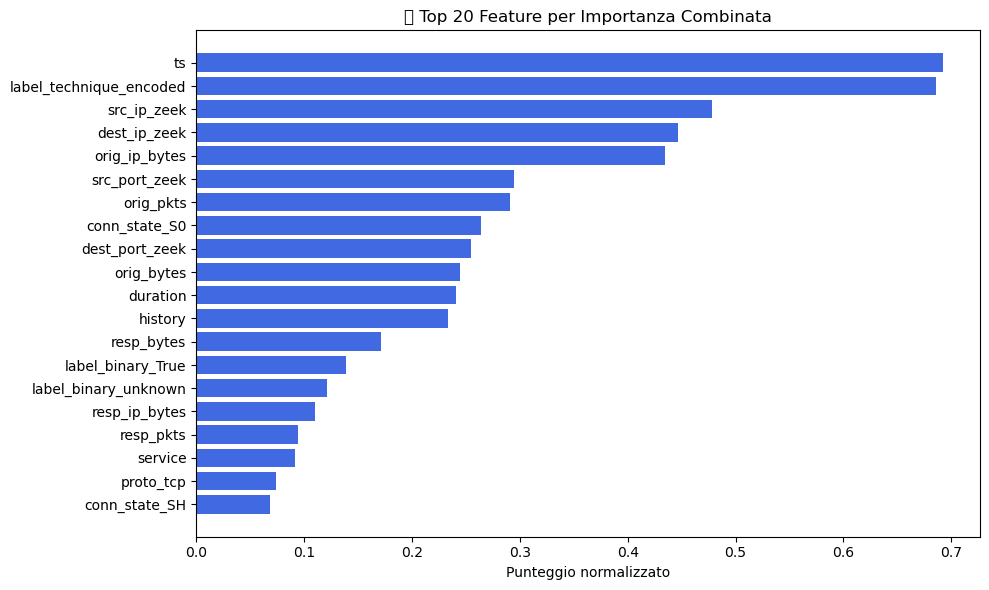


[INFO] Top 10 feature selezionate:
                    Feature  Combined_Score
4                        ts           0.692
1   label_technique_encoded           0.686
7               src_ip_zeek           0.478
13             dest_ip_zeek           0.446
14            orig_ip_bytes           0.434
28            src_port_zeek           0.294
16                orig_pkts           0.291
2             conn_state_S0           0.264
12           dest_port_zeek           0.255
35               orig_bytes           0.244
20                 duration           0.241
22                  history           0.234
19               resp_bytes           0.171
5         label_binary_True           0.139
6      label_binary_unknown           0.121
18            resp_ip_bytes           0.110
17                resp_pkts           0.094
9                   service           0.091
8                 proto_tcp           0.074
3             conn_state_SH           0.069


In [8]:
# ==============================================
# - BLOCCO 7 — Feature Selection Avanzata
# ==============================================
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("[INFO] Inizio feature selection avanzata (versione robusta)...")

# 🔹 Seleziona feature e target
X_full = data_preproc.drop(columns=['label_tactic', 'label_technique'])
y = data_preproc['label_tactic_encoded']

# 🔸 1. Mantieni solo colonne numeriche
X = X_full.select_dtypes(include=[np.number])

# 🔸 2. Gestisci eventuali NaN o infiniti
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# 🔹 Rimuove colonne a varianza nulla
sel = VarianceThreshold(threshold=0)
X = pd.DataFrame(sel.fit_transform(X), columns=np.array(X.columns)[sel.get_support()])

# ==================================================
# 1️⃣ ANOVA F-Test — relazione lineare con la classe
# ==================================================
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA_F': anova_selector.scores_
}).sort_values(by='ANOVA_F', ascending=False)

# ==================================================
# 2️⃣ Mutual Information — relazioni non lineari
# ==================================================
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Info': mi_scores
}).sort_values(by='Mutual_Info', ascending=False)

# ==================================================
# 3️⃣ Random Forest Importance — solo per ranking, NON per training
# ==================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

# ==================================================
# 🔹 Combina i risultati e normalizza
# ==================================================
feature_rank = anova_scores.merge(mi_scores_df, on='Feature').merge(rf_importances, on='Feature')
for col in ['ANOVA_F', 'Mutual_Info', 'RF_Importance']:
    feature_rank[col] = (feature_rank[col] - feature_rank[col].min()) / (feature_rank[col].max() - feature_rank[col].min())

feature_rank['Combined_Score'] = (
    0.4 * feature_rank['RF_Importance'] +
    0.3 * feature_rank['Mutual_Info'] +
    0.3 * feature_rank['ANOVA_F']
)

feature_rank = feature_rank.sort_values(by='Combined_Score', ascending=False)

# 🔹 Visualizzazione top feature
top_features = feature_rank.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Combined_Score'], color='royalblue')
plt.gca().invert_yaxis()
plt.title("🏆 Top 20 Feature per Importanza Combinata")
plt.xlabel("Punteggio normalizzato")
plt.tight_layout()
plt.show()

print("\n[INFO] Top 10 feature selezionate:")
print(top_features[['Feature', 'Combined_Score']].round(3))


In [9]:
# ==============================================
# - BLOCCO 8 — Train-Test Split + Salvataggio CSV
# ==============================================
from sklearn.model_selection import train_test_split
import os

print("[INFO] Suddivisione Train/Test e salvataggio in corso...")

# 🔹 Seleziona solo le top feature desiderate
top_features_list = feature_rank['Feature'].head(15).tolist()
X_selected = X[top_features_list]

# 🔹 Suddivisione Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 🔹 Crea una cartella per salvare i dataset
SAVE_DIR = r"C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit"
os.makedirs(SAVE_DIR, exist_ok=True)

# 🔹 Salva i dataset in formato CSV
X_train_path = os.path.join(SAVE_DIR, "X_train.csv")
X_test_path  = os.path.join(SAVE_DIR, "X_test.csv")
y_train_path = os.path.join(SAVE_DIR, "y_train.csv")
y_test_path  = os.path.join(SAVE_DIR, "y_test.csv")

X_train.to_csv(X_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_train.to_csv(y_train_path, index=False)
y_test.to_csv(y_test_path, index=False)

print(f"[INFO] ✅ Train/Test split completato e salvato in:\n"
      f" - {X_train_path}\n"
      f" - {X_test_path}\n"
      f" - {y_train_path}\n"
      f" - {y_test_path}")

print(f"[INFO] Dataset pronto per il training: {X_train.shape[0]} train / {X_test.shape[0]} test")


[INFO] Suddivisione Train/Test e salvataggio in corso...
[INFO] ✅ Train/Test split completato e salvato in:
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_train.csv
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_test.csv
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\y_train.csv
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\y_test.csv
[INFO] Dataset pronto per il training: 278716 train / 69680 test


In [10]:
# ==============================================
# - BLOCCO 9 — Binning e Scaling per modelli
# ==============================================
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
import pandas as pd
import numpy as np
import os

print("[INFO] Inizio trasformazioni: binning e scaling...")

# 🔹 Percorsi dei file già salvati
SAVE_DIR = r"C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit"
X_train = pd.read_csv(os.path.join(SAVE_DIR, "X_train.csv"))
X_test = pd.read_csv(os.path.join(SAVE_DIR, "X_test.csv"))
y_train = pd.read_csv(os.path.join(SAVE_DIR, "y_train.csv"))
y_test = pd.read_csv(os.path.join(SAVE_DIR, "y_test.csv"))

# ===================================================
# 1️⃣ BINNING (per Naive Bayes, DecisionTree, RandomForest)
# ===================================================
discretizer = KBinsDiscretizer(
    n_bins=10,          # numero di intervalli
    encode='ordinal',   # codifica numerica
    strategy='quantile' # divisione basata sui quantili (più robusta)
)

X_train_binned = discretizer.fit_transform(X_train)
X_test_binned = discretizer.transform(X_test)

print("[INFO] ✅ Binning completato (KBinsDiscretizer)")
print(f" - X_train_binned shape: {X_train_binned.shape}")
print(f" - X_test_binned shape:  {X_test_binned.shape}")

# ===================================================
# 2️⃣ SCALING (per SVM, LogisticRegression)
# ===================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("[INFO] ✅ Scaling completato (StandardScaler)")
print(f" - X_train_scaled shape: {X_train_scaled.shape}")
print(f" - X_test_scaled shape:  {X_test_scaled.shape}")

# ===================================================
# 3️⃣ Salvataggio versioni trasformate
# ===================================================
np.save(os.path.join(SAVE_DIR, "X_train_binned.npy"), X_train_binned)
np.save(os.path.join(SAVE_DIR, "X_test_binned.npy"), X_test_binned)
np.save(os.path.join(SAVE_DIR, "X_train_scaled.npy"), X_train_scaled)
np.save(os.path.join(SAVE_DIR, "X_test_scaled.npy"), X_test_scaled)

print("[INFO] ✅ Versioni trasformate salvate come file .npy:")
print(f" - {os.path.join(SAVE_DIR, 'X_train_binned.npy')}")
print(f" - {os.path.join(SAVE_DIR, 'X_test_binned.npy')}")
print(f" - {os.path.join(SAVE_DIR, 'X_train_scaled.npy')}")
print(f" - {os.path.join(SAVE_DIR, 'X_test_scaled.npy')}")

print("""
🧠 NOTE:
- Usa i dataset *binned* per: Naive Bayes, Decision Tree, Random Forest.
- Usa i dataset *scaled* per: SVM, Logistic Regression.
""")


[INFO] Inizio trasformazioni: binning e scaling...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\maria\anaco

[INFO] ✅ Binning completato (KBinsDiscretizer)
 - X_train_binned shape: (278716, 15)
 - X_test_binned shape:  (69680, 15)
[INFO] ✅ Scaling completato (StandardScaler)
 - X_train_scaled shape: (278716, 15)
 - X_test_scaled shape:  (69680, 15)
[INFO] ✅ Versioni trasformate salvate come file .npy:
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_train_binned.npy
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_test_binned.npy
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_train_scaled.npy
 - C:\Users\maria\Desktop\Zeek_ML\TrainTestSplit\X_test_scaled.npy

🧠 NOTE:
- Usa i dataset *binned* per: Naive Bayes, Decision Tree, Random Forest.
- Usa i dataset *scaled* per: SVM, Logistic Regression.

